Loaded data shape: (1277, 10)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Tom\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


,Gender,loan_purpose,loan_amount,term,property_value,income,Credit_Score,age,Region,Status
0,Sex Not Available,p3,146500,240,248000,6780,518,45-54,South,0
1,Male,p3,476500,360,638000,5280,884,45-54,North,0
2,Joint,p4,416500,360,0,6720,741,35-44,North,1
3,Joint,p4,336500,360,558000,6840,683,55-64,North,0
4,Joint,p1,476500,360,528000,8040,690,45-54,South,0



Target: Status
Numeric cols: ['loan_amount', 'term', 'property_value', 'income', 'Credit_Score']
Categorical cols: ['Gender', 'loan_purpose', 'age', 'Region']

Missing values (top 15):


loan_amount       0
term              0
property_value    0
income            0
Credit_Score      0
Gender            0
loan_purpose      0
age               0
Region            0
Status            0
dtype: int64

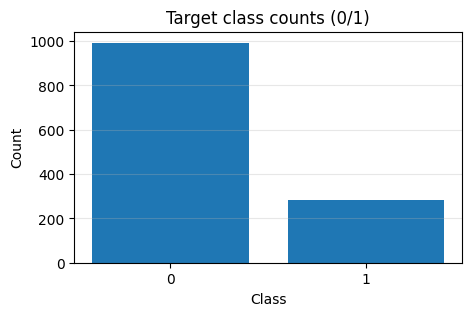

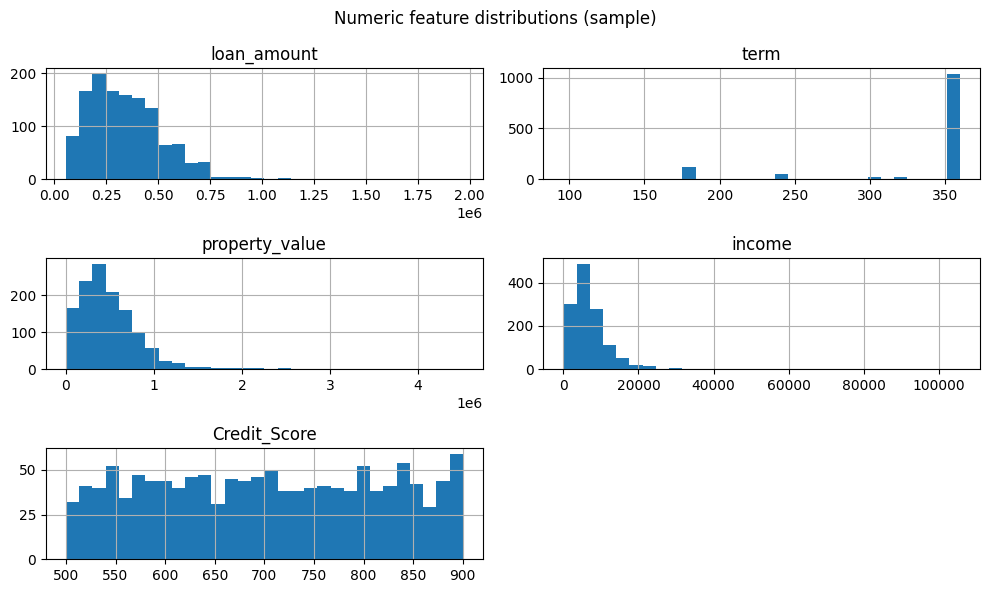

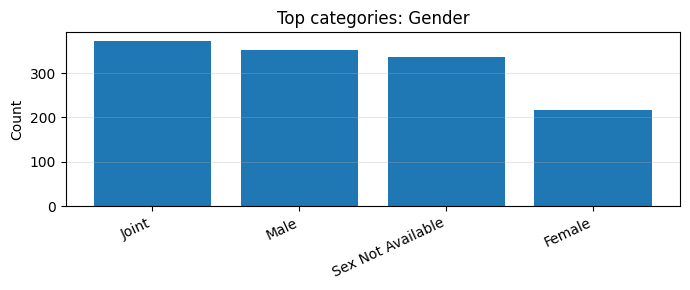

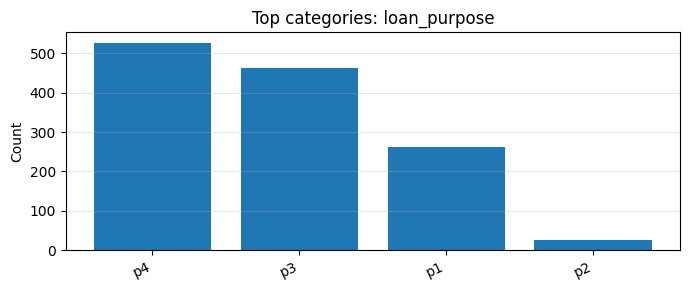

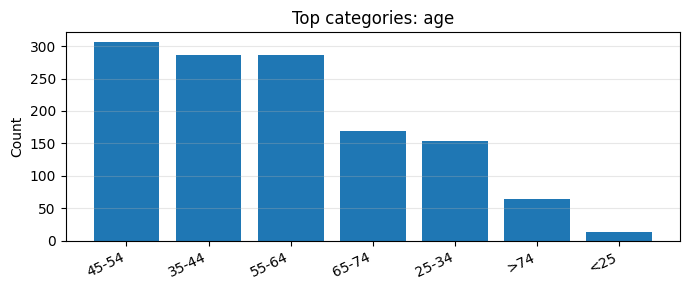


Train size: 1021 | Test size: 256


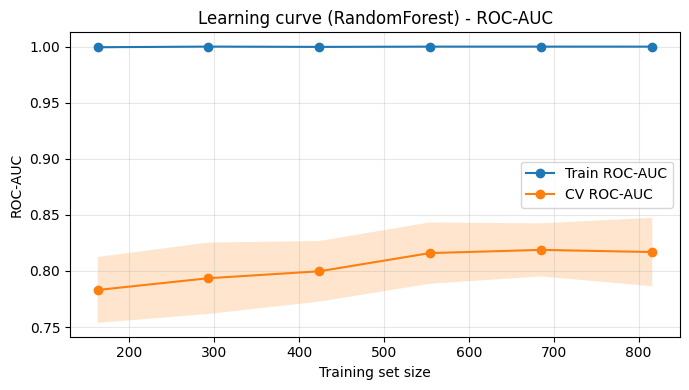


Cross-validation (mean across folds):
   accuracy: 0.882
  precision: 0.907
     recall: 0.524
         f1: 0.663
    roc_auc: 0.816

Hold-out test metrics:
   accuracy: 0.879
  precision: 0.964
     recall: 0.474
         f1: 0.635
    roc_auc: 0.789


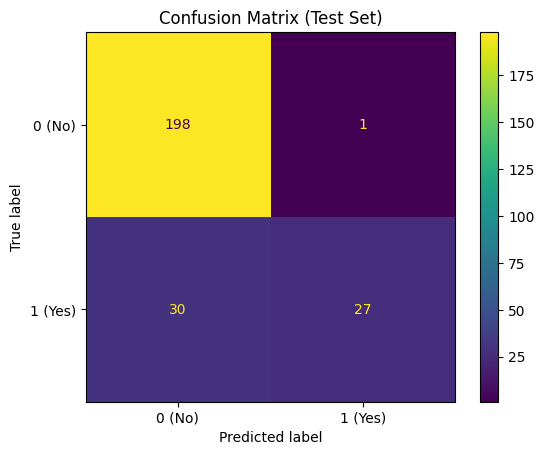

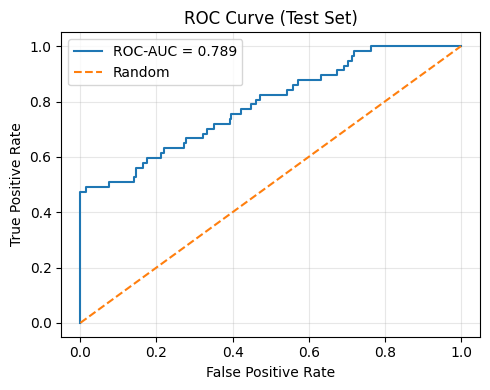


Top 20 feature importances:


,feature,importance
2,property_value,0.410232
3,income,0.121842
4,Credit_Score,0.119119
0,loan_amount,0.114963
1,term,0.022763
6,Gender_Joint,0.021377
8,Gender_Sex Not Available,0.017479
11,loan_purpose_p3,0.015003
15,age_45-54,0.014935
9,loan_purpose_p1,0.013998


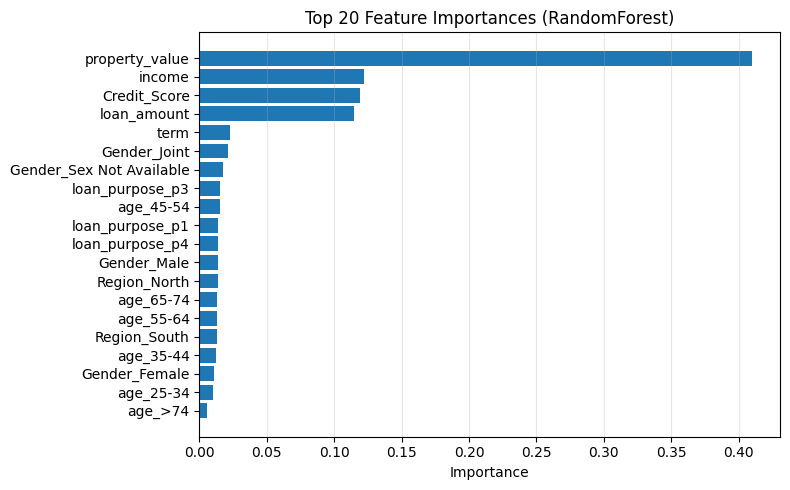


Summary table (CV mean + Test):


,CV_accuracy,CV_precision,CV_recall,CV_f1,CV_roc_auc,TEST_accuracy,TEST_precision,TEST_recall,TEST_f1,TEST_roc_auc
0,0.882473,0.907307,0.524058,0.663422,0.816134,0.878906,0.964286,0.473684,0.635294,0.789209


In [4]:
# =========================
# RandomForest end-to-end notebook script
# - Loads CSV
# - Lets you control input columns easily
# - Shows EDA charts + learning curves
# - Trains RandomForest (with preprocessing)
# - Outputs CV + test metrics, confusion matrix, ROC curve, feature importances
# =========================

import numpy as np
import pandas as pd
!pip install matplotlib scikit-learn --quiet
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# -------------------------
# 1) CONFIG (EDIT THESE)
# -------------------------
CSV_PATH = "Consumer_train_data.csv"  # or "/mnt/data/Consumer_train_data.csv" if needed

# Target column name (edit this to match your CSV)
TARGET = 'Status'  # e.g. "default_flag" or "cb_person_default_on_file"

# Optional: explicitly control which columns to use
# If you set these lists, the model will ONLY use them.
NUMERIC_COLS = []       # e.g. ["age", "income", "loan_amnt"]
CATEGORICAL_COLS = []   # e.g. ["home_ownership"]

# Optional: drop obvious ID-like columns (adjust as needed)
DROP_COLS_IF_PRESENT = ["id", "ID", "customer_id", "CustomerID"]

# Train/test split
TEST_SIZE = 0.2
RANDOM_STATE = 42

# RandomForest settings
RF_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Cross-validation settings
CV_FOLDS = 5

# -------------------------
# 2) LOAD DATA
# -------------------------
df = pd.read_csv(CSV_PATH)

# Drop id-like columns if present (keeps model cleaner)
for col in DROP_COLS_IF_PRESENT:
    if col in df.columns:
        df = df.drop(columns=[col])

print("Loaded data shape:", df.shape)
display(df.head())

# -------------------------
# 3) CHOOSE TARGET (EASY + SAFE)
# -------------------------
if TARGET is None:
    # Try common target names. Add your own if needed.
    common_targets = [
        "target", "Target", "label", "Label",
        "default", "Default", "default_flag",
        "cb_person_default_on_file"
    ]
    found = [c for c in common_targets if c in df.columns]
    if len(found) == 1:
        TARGET = found[0]
        print(f"[Auto] Using TARGET='{TARGET}'")
    else:
        raise ValueError(
            "TARGET is not set and couldn't be auto-detected.\n"
            f"Set TARGET = 'Status' at the top.\n"
            f"Available columns:\n{list(df.columns)}"
        )

# If target is Y/N, map to 1/0 (common for default datasets)
if df[TARGET].dtype == object:
    unique_vals = df[TARGET].dropna().unique()
    if set(unique_vals).issubset({"Y", "N"}):
        df[TARGET] = df[TARGET].map({"N": 0, "Y": 1})

# Basic target check
if df[TARGET].nunique() != 2:
    raise ValueError(f"TARGET column '{TARGET}' is not binary. Unique values: {df[TARGET].unique()}")

# -------------------------
# 4) CONTROL FEATURES (columns)
# -------------------------
# If you explicitly set NUMERIC_COLS / CATEGORICAL_COLS above, we use them.
# Otherwise, we infer:
# - numeric: number dtypes
# - categorical: object/category/bool
if len(NUMERIC_COLS) == 0 and len(CATEGORICAL_COLS) == 0:
    feature_cols = [c for c in df.columns if c != TARGET]
    inferred_numeric = df[feature_cols].select_dtypes(include=["number"]).columns.tolist()
    inferred_categorical = df[feature_cols].select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    NUMERIC_COLS = inferred_numeric
    CATEGORICAL_COLS = inferred_categorical

print("\nTarget:", TARGET)
print("Numeric cols:", NUMERIC_COLS)
print("Categorical cols:", CATEGORICAL_COLS)

FEATURES = NUMERIC_COLS + CATEGORICAL_COLS
X = df[FEATURES].copy()
y = df[TARGET].copy()

# -------------------------
# 5) QUICK DATA CHECKS + EDA CHARTS
# -------------------------
print("\nMissing values (top 15):")
display(df[FEATURES + [TARGET]].isna().sum().sort_values(ascending=False).head(15))

# Target distribution chart
target_counts = y.value_counts().sort_index()
plt.figure(figsize=(5, 3))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target class counts (0/1)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Numeric feature histograms (first up to 6)
num_to_plot = NUMERIC_COLS[:6]
if len(num_to_plot) > 0:
    df[num_to_plot].hist(figsize=(10, 6), bins=30)
    plt.suptitle("Numeric feature distributions (sample)")
    plt.tight_layout()
    plt.show()

# Categorical feature counts (first up to 3)
cat_to_plot = CATEGORICAL_COLS[:3]
for col in cat_to_plot:
    vc = df[col].astype(str).value_counts().head(12)
    plt.figure(figsize=(7, 3))
    plt.bar(vc.index, vc.values)
    plt.title(f"Top categories: {col}")
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Count")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------
# 6) TRAIN/TEST SPLIT
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"\nTrain size: {len(X_train)} | Test size: {len(X_test)}")

# -------------------------
# 7) PREPROCESSING + MODEL (Pipeline)
# -------------------------
# RandomForest doesn't require scaling, but it DOES require numeric inputs.
# We'll one-hot encode categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATEGORICAL_COLS),
    ],
    remainder="drop"
)

rf = RandomForestClassifier(**RF_PARAMS)

model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("rf", rf),
    ]
)

# -------------------------
# 8) "LEARNING PROCESS" VISUAL: Learning Curve
# -------------------------
# This shows how model performance changes as you train with more data.
# (We use ROC-AUC if available; for binary classification, it's usually best.)
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.2, 1.0, 6),
    n_jobs=1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(7, 4))
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Learning curve (RandomForest) - ROC-AUC")
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 9) CROSS-VALIDATION METRICS (on training set)
# -------------------------
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=1
)

cv_summary = {k.replace("test_", ""): float(np.mean(v)) for k, v in cv_results.items() if k.startswith("test_")}
print("\nCross-validation (mean across folds):")
for k, v in cv_summary.items():
    print(f"  {k:>9}: {v:.3f}")

# -------------------------
# 10) FIT MODEL + TEST EVALUATION
# -------------------------
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Probabilities for ROC-AUC / ROC curve (RandomForest supports this)
y_prob = model.predict_proba(X_test)[:, 1]

test_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_prob),
}

print("\nHold-out test metrics:")
for k, v in test_metrics.items():
    print(f"  {k:>9}: {v:.3f}")

# -------------------------
# 11) CONFUSION MATRIX (visual)
# -------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0 (No)", "1 (Yes)"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

# -------------------------
# 12) ROC CURVE (visual)
# -------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {test_metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.title("ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 13) FEATURE IMPORTANCE (visual)
# -------------------------
# We need the final feature names AFTER one-hot encoding.
prep = model.named_steps["prep"]
rf_fitted = model.named_steps["rf"]

feature_names = []

# Numeric features (passthrough)
feature_names.extend(NUMERIC_COLS)

# Categorical one-hot feature names
if len(CATEGORICAL_COLS) > 0:
    ohe = prep.named_transformers_["cat"]
    ohe_names = ohe.get_feature_names_out(CATEGORICAL_COLS).tolist()
    feature_names.extend(ohe_names)

importances = rf_fitted.feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

print("\nTop 20 feature importances:")
display(fi.head(20))

top_n = 20
plt.figure(figsize=(8, 5))
plt.barh(fi.head(top_n)["feature"][::-1], fi.head(top_n)["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------
# 14) ONE CLEAN SUMMARY TABLE
# -------------------------
summary = pd.DataFrame([{
    **{f"CV_{k}": v for k, v in cv_summary.items()},
    **{f"TEST_{k}": v for k, v in test_metrics.items()},
}])

print("\nSummary table (CV mean + Test):")
display(summary)


In [ ]:
import os

# Path to your external test CSV (adjust if needed)
TEST_CSV_PATH = "Consumer_test_data.csv"

if not os.path.exists(TEST_CSV_PATH):
    print(f"Test CSV not found at {TEST_CSV_PATH}. Place the file in the notebook folder or update TEST_CSV_PATH.")
else:
    test_df = pd.read_csv(TEST_CSV_PATH)
    # Drop id-like columns if present to match training preprocessing
    for col in DROP_COLS_IF_PRESENT:
        if col in test_df.columns:
            test_df = test_df.drop(columns=[col])

    # Ensure required feature columns exist (add as NaN if missing)
    missing = [c for c in FEATURES if c not in test_df.columns]
    if missing:
        print(f"Warning: test data is missing {len(missing)} feature columns. Adding as NaN: {missing}")
        for c in missing:
            test_df[c] = np.nan

    # Build feature matrix using same FEATURES order
    X_new = test_df[FEATURES].copy()

    # Determine if target is present in the external test file
    y_new = test_df[TARGET] if TARGET in test_df.columns else None

    # Predict using the already-trained pipeline 'model'
    preds = model.predict(X_new)
    probs = model.predict_proba(X_new)[:, 1] if hasattr(model, 'predict_proba') else None

    # Attach predictions to dataframe and save
    test_df['predicted_label'] = preds
    if probs is not None:
        test_df['predicted_proba'] = probs
    out_path = TEST_CSV_PATH.replace('.csv', '') + '_with_preds.csv'
    test_df.to_csv(out_path, index=False)
    print(f"Saved predictions to {out_path}")

    # If true labels are present, compute and show metrics + plots
    if y_new is not None:
        # compute metrics
        acc = accuracy_score(y_new, preds)
        prec = precision_score(y_new, preds, zero_division=0)
        rec = recall_score(y_new, preds, zero_division=0)
        f1 = f1_score(y_new, preds, zero_division=0)
        roc = roc_auc_score(y_new, probs) if probs is not None else float('nan')

        # Build an outcomes table (single-row DataFrame) with metrics and basic counts
        counts = {
            'total': int(len(y_new)),
            'true_positives': int((y_new == 1).sum()),
            'true_negatives': int((y_new == 0).sum()),
            'predicted_positives': int((preds == 1).sum()),
            'predicted_negatives': int((preds == 0).sum()),
        }

        metrics = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
        }

        outcomes = {**counts, **metrics}
        outcomes_df = pd.DataFrame([outcomes])

        # Round metric columns for display convenience
        for c in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            if c in outcomes_df.columns:
                outcomes_df[c] = outcomes_df[c].round(3)

        print('\nOutcomes summary (external test CSV):')
        display(outcomes_df)

        # Confusion matrix
        cm = confusion_matrix(y_new, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
        disp.plot(values_format='d')
        plt.title('Confusion Matrix (External Test CSV)')
        plt.show()

        # ROC curve (if probabilities available)
        if probs is not None:
            fpr, tpr, _ = roc_curve(y_new, probs)
            plt.figure(figsize=(5, 4))
            plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.3f}")
            plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
            plt.title('ROC Curve (External Test CSV)')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.show()
    else:
        print('No target column found in test CSV. Predictions saved; provide target column to compute metrics.')

Saved predictions to Consumer_test_data_with_preds.csv
No target column found in test CSV. Predictions saved; provide target column to compute metrics.


Best LTV threshold (by F1 for class 1): 0.2559
F1_1=0.205, precision_1=0.128, recall_1=0.509
Representative property_value cutoff for median loan_amount (311500.00): <= 1217069.74 -> predicts 1
Saved threshold search results to ltv_threshold_search_results_class1.csv


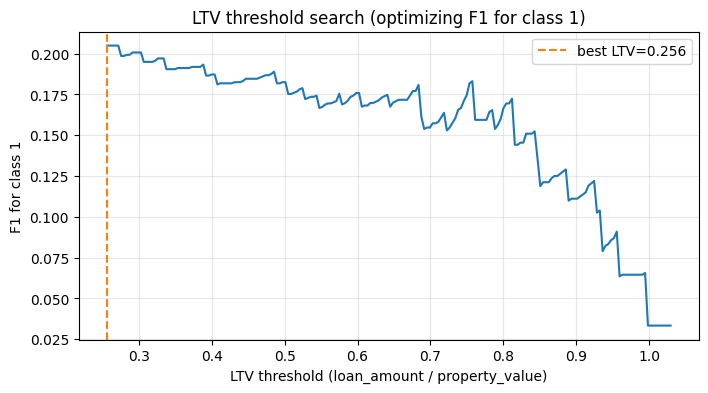

,ltv_thresh,f1_1,prec_1,recall_1
0,0.255943,0.204947,0.128319,0.508772
1,0.259830,0.204947,0.128319,0.508772
2,0.263718,0.204947,0.128319,0.508772
3,0.267606,0.204947,0.128319,0.508772
4,0.271494,0.204947,0.128319,0.508772
11,0.298709,0.200717,0.126126,0.491228
10,0.294821,0.200717,0.126126,0.491228
9,0.290933,0.200717,0.126126,0.491228
12,0.302597,0.200717,0.126126,0.491228
8,0.287046,0.199288,0.125000,0.491228


In [9]:
# === Optimal LTV threshold analysis for class 1 (positive) ===
# Requires: X_test, y_test (from notebook), and features 'loan_amount' and 'property_value' present
if 'loan_amount' not in X_test.columns or 'property_value' not in X_test.columns:
    print("Columns 'loan_amount' and/or 'property_value' not found in X_test. Add/rename features accordingly.")
else:
    # Prepare LTV (loan_amount / property_value); avoid division by zero
    loan = X_test['loan_amount'].astype(float).copy()
    prop = X_test['property_value'].replace(0, np.nan).astype(float).copy()
    ltv = loan / (prop + 1e-9)
    ltv = ltv.replace([np.inf, -np.inf], np.nan)

    # Use central percentiles to avoid extreme outliers for threshold grid
    low = np.nanpercentile(ltv, 1)
    high = np.nanpercentile(ltv, 99)
    if np.isnan(low) or np.isnan(high) or low >= high:
        print('Unable to build threshold grid from LTV values; inspect loan/property_value columns.')
    else:
        thresh_vals = np.linspace(low, high, 200)
        results = []
        for t in thresh_vals:
            # rule: predict 1 when LTV > t, else 0; unknown LTV treated as 1 (conservative)
            y_pred_t = (ltv > t).astype(int).fillna(1).values
            # compute metrics for class 1 (positive)
            f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
            prec_1 = precision_score(y_test, y_pred_t, pos_label=1, zero_division=0)
            rec_1 = recall_score(y_test, y_pred_t, pos_label=1, zero_division=0)
            results.append((t, f1_1, prec_1, rec_1))

        res_df = pd.DataFrame(results, columns=['ltv_thresh', 'f1_1', 'prec_1', 'recall_1'])
        # best by F1 for class 1
        best = res_df.sort_values('f1_1', ascending=False).iloc[0]
        print(f"Best LTV threshold (by F1 for class 1): {best['ltv_thresh']:.4f}")
        print(f"F1_1={best['f1_1']:.3f}, precision_1={best['prec_1']:.3f}, recall_1={best['recall_1']:.3f}")

        # Convert LTV threshold to a representative property_value cutoff for a given loan (median)
        med_loan = loan.median()
        # For predict 1 when LTV > thresh => property_value < loan / thresh predicts 1
        if best['ltv_thresh'] > 0 and not np.isnan(med_loan):
            prop_cutoff_for_median_loan = med_loan / best['ltv_thresh']
            print(f"Representative property_value cutoff for median loan_amount ({med_loan:.2f}): <= {prop_cutoff_for_median_loan:.2f} -> predicts 1")
        else:
            print('Cannot compute representative property_value cutoff (division by zero or NaN).')

        # Save full search results for inspection
        res_df.to_csv('ltv_threshold_search_results_class1.csv', index=False)
        print('Saved threshold search results to ltv_threshold_search_results_class1.csv')

        # Plot F1 curve vs threshold
        plt.figure(figsize=(8,4))
        plt.plot(res_df['ltv_thresh'], res_df['f1_1'], '-', color='C0')
        plt.axvline(best['ltv_thresh'], color='C1', linestyle='--', label=f"best LTV={best['ltv_thresh']:.3f}")
        plt.xlabel('LTV threshold (loan_amount / property_value)')
        plt.ylabel('F1 for class 1')
        plt.title('LTV threshold search (optimizing F1 for class 1)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # Show top candidate thresholds
        display(res_df.sort_values('f1_1', ascending=False).head(10))

Best LTV threshold for class 1 (F1): 0.255943  | F1_1=0.205
Best LTV threshold for class 0 (F1): 0.994638  | F1_0=0.874


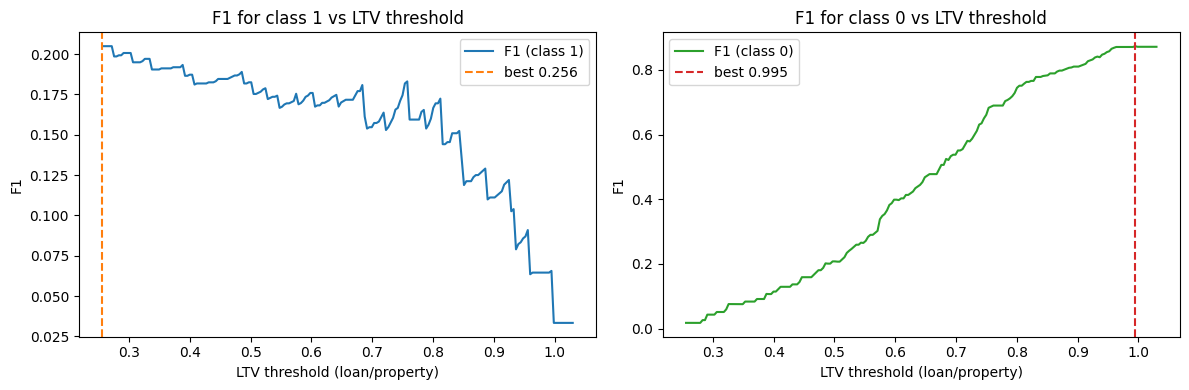

Fraction predicted 0 (rule best1): 0.117  | Fraction predicted 1: 0.883
Fraction predicted 0 (rule best0): 0.984  | Fraction predicted 1: 0.016
Saved detailed per-row predictions and probs to ltv_predictions_detailed.csv

Top rows by model_prob_0 (most likely class 0 by model):
Saved detailed per-row predictions and probs to ltv_predictions_detailed.csv

Top rows by model_prob_0 (most likely class 0 by model):


,loan_amount,term,property_value,income,Credit_Score,Gender,loan_purpose,age,Region,ltv,model_pred_proba_1,model_prob_0,pred_by_ltv_best1_0.255943,pred_by_ltv_best0_0.994638
835,516500,360,988000.0,12600,674,Joint,p4,55-64,North,0.522773,0.018327,0.981673,1,0
127,456500,360,518000.0,7560,810,Joint,p1,35-44,North,0.881274,0.023598,0.976402,1,0
858,646500,360,688000.0,13800,793,Joint,p4,35-44,North,0.939680,0.030891,0.969109,1,0
2,416500,360,NaN,6720,741,Joint,p4,35-44,North,NaN,0.032207,0.967793,0,0
888,696500,360,958000.0,13800,803,Joint,p4,45-54,North,0.727035,0.037221,0.962779,1,0
603,426500,360,998000.0,12240,689,Joint,p4,55-64,South,0.427355,0.039203,0.960797,1,0
177,456500,360,1508000.0,8520,584,Joint,p4,45-54,North,0.302719,0.049991,0.950009,1,0
906,456500,360,528000.0,9720,770,Joint,p4,45-54,South,0.864583,0.051102,0.948898,1,0
482,486500,360,NaN,8940,775,Joint,p3,45-54,North,NaN,0.054134,0.945866,0,0
1046,336500,180,528000.0,6360,575,Joint,p3,55-64,North,0.637311,0.058117,0.941883,1,0



Rows with lowest LTV (strong collateral):


,loan_amount,term,property_value,income,Credit_Score,Gender,loan_purpose,age,Region,ltv,model_pred_proba_1,model_prob_0,pred_by_ltv_best1_0.255943,pred_by_ltv_best0_0.994638
765,86500,360,408000.0,2880,795,Sex Not Available,p3,45-54,South,0.212010,0.218048,0.781952,0,0
936,76500,360,358000.0,3600,760,Sex Not Available,p2,25-34,South,0.213687,0.334242,0.665758,0,0
182,266500,180,1068000.0,16380,854,Male,p2,35-44,North,0.249532,0.175557,0.824443,0,0
1074,206500,360,758000.0,2460,541,Male,p3,55-64,South,0.272427,0.251910,0.748090,1,0
1015,86500,180,308000.0,3240,725,Male,p3,55-64,North,0.280844,0.140839,0.859161,1,0
565,246500,360,848000.0,9720,807,Joint,p3,55-64,North,0.290684,0.069919,0.930081,1,0
372,156500,360,538000.0,8400,596,Female,p3,65-74,North,0.290892,0.290063,0.709937,1,0
177,456500,360,1508000.0,8520,584,Joint,p4,45-54,North,0.302719,0.049991,0.950009,1,0
287,206500,360,678000.0,3540,620,Sex Not Available,p2,55-64,South,0.304572,0.346766,0.653234,1,0
733,296500,360,928000.0,5460,899,Male,p4,35-44,North,0.319504,0.246869,0.753131,1,0


In [13]:
# === Inspect best LTV thresholds with cleaning: produce F1-vs-LTV charts for both classes (keep all data) ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Start from X_test but apply the same lightweight cleaning used for external test CSV (no row drops)
Xc = X_test.copy()

# Drop obvious ID-like columns if present
for col in DROP_COLS_IF_PRESENT:
    if col in Xc.columns:
        Xc = Xc.drop(columns=[col])

# Ensure required FEATURES exist (add as NaN if missing)
missing = [c for c in FEATURES if c not in Xc.columns]
if missing:
    print(f"Adding missing feature columns as NaN: {missing}")
    for c in missing:
        Xc[c] = np.nan

# Coerce numeric columns to numeric (safe) and handle property_value zeros -> NaN to avoid invalid LTV
for col in NUMERIC_COLS:
    if col in Xc.columns:
        Xc[col] = pd.to_numeric(Xc[col], errors='coerce')
if 'property_value' in Xc.columns:
    Xc['property_value'] = pd.to_numeric(Xc['property_value'], errors='coerce').replace(0, np.nan)
if 'loan_amount' in Xc.columns:
    Xc['loan_amount'] = pd.to_numeric(Xc['loan_amount'], errors='coerce')

# Compute LTV using cleaned features (keep NaN where property missing/zero)
loan = Xc['loan_amount'].astype(float)
prop = Xc['property_value'].astype(float)
ltv = loan / (prop + 1e-9)
ltv = ltv.replace([np.inf, -np.inf], np.nan)

# Build threshold grid from central percentiles of available LTV values (still keep all rows)
valid = ltv.dropna().values
if len(valid) < 10:
    print('Not enough valid LTV values to search thresholds. You can still inspect per-row probabilities.')
else:
    low = np.percentile(valid, 1)
    high = np.percentile(valid, 99)
    if low >= high:
        print('Invalid percentile range for LTV; inspect values.')
    else:
        thresh_vals = np.linspace(low, high, 200)
        rows = []
        for t in thresh_vals:
            # rule: predict 1 when LTV > t, else 0; treat NaN LTV conservatively as 1 (unknown -> risky)
            y_pred = (ltv > t).astype(int).fillna(1).values
            # metrics for class 1 and class 0
            f1_1 = f1_score(y_test, y_pred, pos_label=1)
            f1_0 = f1_score(y_test, y_pred, pos_label=0)
            rows.append((t, f1_1, f1_0))

        res_df = pd.DataFrame(rows, columns=['ltv_thresh', 'f1_1', 'f1_0'])
        best1 = res_df.sort_values('f1_1', ascending=False).iloc[0]
        best0 = res_df.sort_values('f1_0', ascending=False).iloc[0]

        print(f"Best LTV threshold for class 1 (F1): {best1['ltv_thresh']:.6f}  | F1_1={best1['f1_1']:.3f}")
        print(f"Best LTV threshold for class 0 (F1): {best0['ltv_thresh']:.6f}  | F1_0={best0['f1_0']:.3f}")

        # Plot two charts side-by-side: F1 for class 1 and F1 for class 0
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(res_df['ltv_thresh'], res_df['f1_1'], color='C0', label='F1 (class 1)')
        axes[0].axvline(best1['ltv_thresh'], color='C1', linestyle='--', label=f"best {best1['ltv_thresh']:.3f}")
        axes[0].set_title('F1 for class 1 vs LTV threshold')
        axes[0].set_xlabel('LTV threshold (loan/property)')
        axes[0].set_ylabel('F1')
        axes[0].legend()

        axes[1].plot(res_df['ltv_thresh'], res_df['f1_0'], color='C2', label='F1 (class 0)')
        axes[1].axvline(best0['ltv_thresh'], color='C3', linestyle='--', label=f"best {best0['ltv_thresh']:.3f}")
        axes[1].set_title('F1 for class 0 vs LTV threshold')
        axes[1].set_xlabel('LTV threshold (loan/property)')
        axes[1].set_ylabel('F1')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        # Compute and print fraction predicted 0/1 at each chosen threshold
        y_pred_best1 = (ltv > best1['ltv_thresh']).astype(int).fillna(1).values
        frac0_1 = (y_pred_best1 == 0).mean()
        print(f"Fraction predicted 0 (rule best1): {frac0_1:.3f}  | Fraction predicted 1: {1-frac0_1:.3f}")

        y_pred_best0 = (ltv > best0['ltv_thresh']).astype(int).fillna(1).values
        frac0_0 = (y_pred_best0 == 0).mean()
        print(f"Fraction predicted 0 (rule best0): {frac0_0:.3f}  | Fraction predicted 1: {1-frac0_0:.3f}")

# attach model probabilities using cleaned features (if available)
try:
    probs = model.predict_proba(Xc)[:, 1]
    prob0 = 1 - probs
except Exception:
    probs = pd.Series([np.nan]*len(Xc), index=Xc.index)
    prob0 = pd.Series([np.nan]*len(Xc), index=Xc.index)

# Prepare output dataframe (cleaned features + LTV + model probs + LTV-rule preds)
out_df = Xc.copy()
out_df['ltv'] = ltv
out_df['model_pred_proba_1'] = probs
out_df['model_prob_0'] = prob0
if 'res_df' in locals():
    out_df[f"pred_by_ltv_best1_{best1['ltv_thresh']:.6f}"] = (ltv > best1['ltv_thresh']).astype(int).fillna(1).astype(int)
    out_df[f"pred_by_ltv_best0_{best0['ltv_thresh']:.6f}"] = (ltv > best0['ltv_thresh']).astype(int).fillna(1).astype(int)

out_path = 'ltv_predictions_detailed.csv'
out_df.to_csv(out_path, index=False)
print(f'Saved detailed per-row predictions and probs to {out_path}')

print('\nTop rows by model_prob_0 (most likely class 0 by model):')
display(out_df.sort_values('model_prob_0', ascending=False).head(10))
print('\nRows with lowest LTV (strong collateral):')
display(out_df.sort_values('ltv').head(10))